<a href="https://colab.research.google.com/github/hanhluukim/replication-topic-modelling-in-embedding-space/blob/main/notebook_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Das Projekt aus dem Github klonen und in den Projektsordner**

In [1]:
#wenn die Ordner noch nicht geklont ist, soll dieser Fehler zuerst durchgeführt werden.
!git clone https://github.com/hanhluukim/replication-topic-modelling-in-embedding-space.git

Cloning into 'replication-topic-modelling-in-embedding-space'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 400 (delta 113), reused 108 (delta 51), pack-reused 225
Receiving objects: 100% (400/400), 4.75 MiB | 5.81 MiB/s, done.
Resolving deltas: 100% (223/223), done.


In [2]:
cd /content/replication-topic-modelling-in-embedding-space

/content/replication-topic-modelling-in-embedding-space


#**Die benötige Paketen für das Projekt mittels requirements.txt installieren**



In [3]:
# Falls die Packages noch nicht installiert wurden, 
!pip install -r "/content/replication-topic-modelling-in-embedding-space/requirements.txt"

     |████████████████████████████████| 4.0 MB 6.6 MB/s 
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 28.8 MB 2.0 MB/s 
     |████████████████████████████████| 636 kB 42.5 MB/s 
     |████████████████████████████████| 79.9 MB 85 kB/s 
     |████████████████████████████████| 880 kB 44.4 MB/s 
     |████████████████████████████████| 77 kB 2.9 MB/s 
     |████████████████████████████████| 6.6 MB 42.2 MB/s 
     |████████████████████████████████| 1.1 MB 44.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=17ec48d5998d153b551bf2ca078ad7b894a1e34b3723fb791ace7410c5f0ef52
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=3ec949f00ac263342c82047517601ccd94ec9fc8444c353bd50d608466919a99
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80

# **Gebrauchte Paketen importieren**

In [4]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import umap.umap_ as umap
import time
import plotly.express as px
from sklearn import cluster
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# **Vorverarbeitung und BOW-Repräsentationen für Textdaten durchführen**
1. Vocabular erstellen
2. BOW-Repräsentationen für allen Teildatensätzen

In [5]:
from src.preprare_dataset import TextDataLoader

In [6]:
# init TextDataLoader für die Datenquelle 20 News Groups
# Daten abrufen vom Sklearn, tokenisieren und besondere Charaktern entfernen
textsloader = TextDataLoader(source="20newsgroups", train_size=None, test_size=None)
textsloader.load_tokenize_texts("20newsgroups")
# Beispiel von Textdaten
textsloader.show_example_raw_texts(n_docs=2)

loading texts: ...
finished load!
check some sample texts of the dataset
['From', ':', 'lerxst', '@', 'wam', '.', 'umd', '.', 'edu', '(', "where's", 'my', 'thing', ')', 'Subject', ':', 'WHAT', 'car', 'is', 'this', '!', '?', 'Nntp', 'Posting', 'Host', ':', 'rac3', '.', 'wam', '.', 'umd', '.', 'edu', 'Organization', ':', 'University', 'of', 'Maryland', ',', 'College', 'Park', 'Lines', ':', '15', 'I', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'I', 'saw', 'the', 'other', 'day', '.', 'It', 'was', 'a', '2', 'door', 'sports', 'car', ',', 'looked', 'to', 'be', 'from', 'the', 'late', '60s', '/', 'early', '70s', '.', 'It', 'was', 'called', 'a', 'Bricklin', '.', 'The', 'doors', 'were', 'really', 'small', '.', 'In', 'addition', ',', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', '.', 'This', 'is', 'all', 'I', 'know', '.', 'If', 'anyone', 'can', 'tellme', 'a', 'model', 'name', ',', 'engine', 'specs'

In [7]:
# Vorverarbeitung von Daten mit folgenden Schritten:
textsloader.preprocess_texts(length_one_remove=True, punctuation_lower = True, stopwords_filter = True)

start: preprocessing: ...
finised: preprocessing!


In [8]:
# Daten zerlegen für Train, Test und Validation. Erstellen Vocabular aus dem Trainset
textsloader.split_and_create_voca_from_trainset(max_df=0.7, min_df=10, stopwords_remove_from_voca=True)

test-document-frequency: 
[[ 18  17  11  13  18  10  13  20  17  22  15  19  19  10 162  18  10  15
   43  17  10  23  10  12  25  14  13  38  11  12  14  17  22  61  12  33
   27  11  11  17  16  14  34  11  31  20  14  11  13  16  11  11  10  11
   12  12  18  13  10  19  10  17  12  14  10  63  12  14  13  11  28  14
   14  11  22  20  51  18  10  10  22  13  25  24  19  18  11  11  10  13
   21  21  14  10  16  13  12  74  13  13  10  10  11  19  13  11  11  15
   11  31  26  16  14  10  10  11  13  36  10  20  20  13  14  11  43  13
   14  12  22  20  13  15  14  16  10  11  13  16  22  22  54  17  17  11
   31  10  27  18  10  20  20  10  16  27  14  11  11  24  13  20  10  14
   12  17  15 158  12  16  13  20  10  12  14  18  10  11  23  26  12  10
   15  12  14  21  12  21  12  12  15  10  25  14  32  21  13  14  18  11
   17  10  21  10  24  12  24  12  15  12  32  11  12  11  25  15  15  11
   14  15  30  36  21  60  15  11  14  20  16  24  10  18  12  24  11  12
   10  19  1

In [9]:
# Erstellen BOW-Repräsentation für ETM Modell
for_lda_model = False 
word2id, id2word, train_set, test_set, val_set = textsloader.create_bow_and_savebow_for_each_set(for_lda_model=for_lda_model)

length train-documents-indices : 4142
length of the vocabulary: 422


start: creating bow representation...
top 10 - word-id of the doc: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
max word-id: 421
min word-id: 0
max doc-id: 143
min doc-id: 0
all docs: 4142
all words: 4142
docidx unique 144
words unique: 422
ndocs: 144
vocab-size: 422
finised creating bow input!

need normalized bows
start: creating bow representation...
top 10 - word-id of the doc: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
max word-id: 421
min word-id: 0
max doc-id: 104
min doc-id: 0
all docs: 3659
all words: 3659
docidx unique 105
words unique: 420
ndocs: 105
vocab-size: 422
finised creating bow input!

need normalized bows
start: creating bow representation...
top 10 - word-id of the doc: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
max word-id: 421
min word-id: 0
max doc-id: 51
min doc-id: 0
all docs: 1884
all words: 1884
docidx unique 52
words unique: 399
ndocs: 52
vocab-size: 422
finised creating bow input!

need normalized bows
start: creating bow r

# **Vocabular und IDs anzeigen als Beispiel**

---





In [10]:
# show for samples: 100 word2id and id2 word
word2id_df_100 = pd.DataFrame()
word2id_df_100['word'] = list(word2id.keys())[:100]
word2id_df_100['id'] = list(word2id.values())[:100]
word2id_df_100

,word,id
0,cmu,0
1,support,1
2,greater,2
3,asked,3
4,good,4
...,...,...
95,top,95
96,technical,96
97,bbs,97
98,claim,98


# **Die Größe von Datensätzen kontrollieren**

In [11]:
# Kontrollieren die Größen von verschiedenen Datensätzen
print(f'Size of the vocabulary after prprocessing ist: {len(textsloader.vocabulary)}')
print(f'Size of train set: {len(train_set["tokens"])}')
print(f'Size of val set: {len(val_set["tokens"])}')
print(f'Size of test set: {len(test_set["test"]["tokens"])}')

Size of the vocabulary after prprocessing ist: 422
Size of train set: 144
Size of val set: 101
Size of test set: 105


# **Dokumenten wiederstellen für Word2Vec Embedding**

---



In [12]:
# re-erstellen von Dokumenten nach der Vorverarbeitungen. Die Dokumenten sind in Wörtern und werden für Word-Embedding Training benutzt
docs_tr, docs_t, docs_v = textsloader.get_docs_in_words_for_each_set()
train_docs_df = pd.DataFrame()
train_docs_df['text-after-preprocessing'] = [' '.join(doc) for doc in docs_tr[:100]]
train_docs_df

,text-after-preprocessing
0,steve article west nntp posting host writes ro...
1,article free writes high speed mind hardware n...
2,system reply uk canada back months posted time...
3,nntp posting host article access net access wr...
4,cs disclaimer public access system run univers...
...,...
95,reply win net win net line mail program called...
96,state university nntp posting host keywords di...
97,microsoft distribution usa article news cs de ...
98,pay graphics view ca dan writes remember posti...


# **Word-Embedding trainieren mit dem Traindatensatz**

In [22]:
from src.embedding import WordEmbeddingCreator
from pathlib import Path
save_path = Path.joinpath(Path.cwd(), "vocab_embedding.txt")
wb_creator = WordEmbeddingCreator(model_name="cbow", documents = docs_tr, save_path= save_path)
wb_creator.train(min_count=0, embedding_size= 10)
vocab = list(word2id.keys())
wb_creator.create_and_save_vocab_embedding(vocab, save_path)
wb_creator.cluster_words(embedding_save_path = save_path, fig_path = Path('figures'), n_components=2)

word-embedding train begins
word-embedding train finished
length of vocabulary from word-embedding model 422
length of the vocabulary of prepraring-dataset-vocabulary: 422


100%|██████████| 422/422 [00:00<00:00, 35035.56it/s]


Cluster id labels for inputted data
[9 3 3 9 9 9 9 8 6 3 8 6 8 2 2 1 1 4 1 2 4 8 3 6 7 4 1 1 1 3 4 3 7 1 6 6 3
 2 3 4 3 9 7 1 9 7 2 6 3 5 4 9 2 3 9 4 9 7 9 2 1 7 2 9 2 9 2 3 9 4 7 6 7 7
 8 9 7 2 3 4 1 8 3 3 5 1 6 1 1 9 2 7 5 1 8 5 8 4 3 2 7 8 3 7 9 3 1 7 7 7 8
 3 4 2 9 3 8 8 3 6 6 2 3 0 0 9 4 8 6 2 1 1 1 0 9 2 6 2 6 0 8 9 4 7 9 2 1 0
 2 7 6 7 3 3 1 5 1 3 0 1 4 9 1 7 5 7 0 4 2 9 7 5 5 6 6 8 8 7 0 0 2 2 2 5 9
 0 7 8 2 2 7 0 2 1 1 4 6 4 2 9 5 0 9 7 5 5 1 3 0 0 4 1 6 3 5 6 9 1 6 6 4 3
 8 3 8 5 9 2 7 8 0 4 4 7 3 2 0 2 4 1 7 4 1 7 8 0 7 2 3 6 1 1 4 8 3 4 6 6 6
 9 1 6 8 0 6 8 7 7 4 9 9 2 7 0 7 1 5 6 2 4 0 6 7 7 8 8 2 6 1 2 3 2 7 8 7 5
 1 3 3 7 3 6 9 4 8 7 9 4 3 8 7 1 4 1 5 7 7 8 2 8 5 0 6 4 0 8 7 7 2 4 9 7 6
 0 0 8 3 4 7 7 8 6 4 1 6 2 7 7 8 7 7 9 9 7 1 1 4 3 0 0 0 1 4 2 2 2 8 4 2 5
 2 8 7 6 4 5 3 8 4 5 0 7 4 6 9 6 6 4 8 6 5 2 7 1 6 1 7 5 0 0 4 8 1 7 1 6 5
 6 2 0 6 8 0 0 5 1 6 5 7 6 4 8]
Centroids data
[[ 0.00186341  0.00090625 -0.00414835 -0.00456915  0.01119775 -0.00805125
   0.0068034  -0.0

True

In [14]:
v = list(wb_creator.model.wv.vocab)[0]
vec = list(wb_creator.model.wv.__getitem__(v))
print(f'word-embedding of the word-- {v}: ')
print(f'vector: {vec}')
print(f'dim of vector: {len(vec)}')

word-embedding of the word-- steve: 
vector: [-0.03008843, 0.08728182, -0.017987255, 0.034843035, 0.013637893, 0.08920556, -0.06917789, -0.018850897, -0.063429914, 0.054515846]
dim of vector: 10


# **Word-Embeddings visualieren als Beispiel**


In [15]:
# read word-embedding files
with open(save_path) as f:
  lines = f.readlines()
embedding_data = []
words_data = []
for t in lines:
  w = t.split("\t")[0]
  v = [float(e) for e in t.split("\t")[1].split(" ")]
  words_data.append(w)
  embedding_data.append(v)

In [16]:
# clustering words with KMeans and Words-Vectors
kmeans = cluster.KMeans(n_clusters=10)
kmeans.fit(embedding_data)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)

Cluster id labels for inputted data
[4 0 0 4 4 4 4 3 3 0 3 5 2 8 6 9 4 1 0 8 2 1 8 5 6 3 9 2 9 0 1 0 6 6 5 5 0
 8 0 1 0 4 0 9 4 6 1 5 8 2 1 4 8 0 4 3 4 0 4 8 2 0 6 4 8 4 5 0 4 1 6 5 6 8
 3 4 6 5 0 2 9 3 0 0 2 9 5 9 6 4 2 6 2 9 3 2 3 3 8 8 6 3 0 6 4 8 9 2 5 6 7
 0 1 2 4 0 9 3 0 0 5 8 0 7 1 4 0 3 5 2 9 9 9 9 4 2 7 9 5 7 3 8 1 6 4 8 9 7
 8 6 5 6 0 9 9 5 9 0 7 4 1 9 2 6 3 6 1 1 8 4 0 2 3 5 5 6 3 8 7 1 9 2 2 2 8
 1 0 0 8 8 6 7 9 9 4 1 7 2 5 8 3 1 4 6 5 5 9 0 7 7 2 6 5 8 2 5 4 9 5 5 1 0
 3 8 3 3 4 2 6 3 7 2 1 6 0 6 1 8 9 9 6 0 9 6 1 7 6 0 0 5 9 2 1 3 9 2 5 5 5
 8 9 5 6 7 3 7 6 6 1 4 4 9 6 1 6 4 3 5 9 1 7 5 6 6 1 1 6 5 9 2 0 0 6 3 6 1
 6 8 8 6 0 5 4 1 3 0 4 1 8 2 6 9 2 9 5 6 6 3 2 3 2 7 5 2 1 3 6 6 2 2 4 6 5
 7 1 7 0 2 6 6 3 5 1 9 3 2 6 6 3 6 3 4 8 6 9 9 0 8 7 1 7 9 0 2 8 8 6 1 2 3
 2 3 0 5 2 2 8 2 1 5 1 6 3 5 4 5 5 2 3 5 2 0 6 2 5 6 6 7 5 7 1 1 9 3 9 7 2
 5 8 7 5 1 7 1 2 9 5 2 6 5 1 3]
Centroids data
[[ 0.02654559  0.07123066 -0.01534187  0.01808528 -0.03019339  0.03397408
  -0.06502702 -0.0

In [17]:
# dimension reduction with umap
start = time.time()
reducer = umap.UMAP(random_state=42,n_components=3)
embedding = reducer.fit_transform(embedding_data)
print('Duration: {} seconds'.format(time.time() - start))

# show samples after dim-reduction in dataframe
wb = pd.DataFrame(embedding, columns=['x', 'y', 'z'])
wb['word'] = words_data
wb['cluster'] = ['cluster ' + str(c) for c in labels]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Duration: 16.986818075180054 seconds


In [18]:
# visualization
fig = px.scatter_3d(wb, 
                    text = wb['word'],
                    x='x', y='y', z='z',
                    color = wb['cluster'],
                    title ="word-embedding-samples")
fig.show()

# **ETM-Model trainieren**

In [19]:
# using DocSet to use easier the modul DataSet from torch
from src.train_etm import DocSet, TrainETM
from src.etm import ETM

vocab_size = len(list(word2id.keys()))
tr_set = DocSet("train", vocab_size, train_set)
print(len(tr_set))
print(tr_set.__getitem__(0))

144
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 

1000
adam
number of batches: 24
Epoch: 0/1000  -  Loss: 173.89637756347656
Epoch: 1/1000  -  Loss: 173.88658142089844
Epoch: 2/1000  -  Loss: 173.8802947998047
Epoch: 3/1000  -  Loss: 173.8724822998047
Epoch: 4/1000  -  Loss: 173.8698272705078
Epoch: 5/1000  -  Loss: 173.86524963378906
Epoch: 6/1000  -  Loss: 173.86151123046875
Epoch: 7/1000  -  Loss: 173.8585662841797
Epoch: 8/1000  -  Loss: 173.8630828857422
Epoch: 9/1000  -  Loss: 173.8540496826172
Epoch: 10/1000  -  Loss: 173.8553466796875
Epoch: 11/1000  -  Loss: 173.85289001464844
Epoch: 12/1000  -  Loss: 173.84881591796875
Epoch: 13/1000  -  Loss: 173.84461975097656
Epoch: 14/1000  -  Loss: 173.8428497314453
Epoch: 15/1000  -  Loss: 173.84361267089844
Epoch: 16/1000  -  Loss: 173.83802795410156
Epoch: 17/1000  -  Loss: 173.8377685546875
Epoch: 18/1000  -  Loss: 173.83689880371094
Epoch: 19/1000  -  Loss: 173.83631896972656
Epoch: 20/1000  -  Loss: 173.8359832763672
Epoch: 21/1000  -  Loss: 173.8358612060547
Epoch: 22/1000  -  Lo

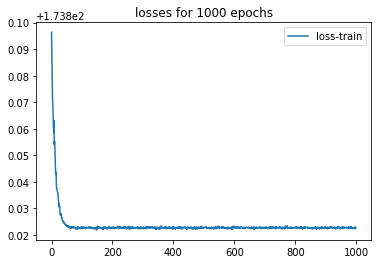

In [20]:
num_topics = 5
t_hidden_size = 100
rho_size = len(embedding_data[0])
emb_size = len(embedding_data[0])
theta_act = "relu"

class TrainArguments:
      def __init__(self, epochs, batch_size, log_interval):
          self.epochs = epochs
          self.batch_size = batch_size
          self.log_interval = log_interval

class OptimizerArguments:
      def __init__(self, optimizer_name, lr, wdecay):
            self.optimizer = optimizer_name
            self.lr = lr
            self.wdecay = wdecay
            
train_args = TrainArguments(epochs=1000, batch_size=6, log_interval=None)
optimizer_args = OptimizerArguments(optimizer_name="adam", lr=0.001, wdecay=0.1)

print(train_args.epochs)
print(optimizer_args.optimizer)

training_set = train_set

# define the ETM-model with setting-parameters
etm_model = ETM(
      num_topics, 
      vocab_size, 
      t_hidden_size, rho_size, emb_size, theta_act, 
      embedding_data, 
      enc_drop=0.5)

# start training
train_class = TrainETM().train(
    etm_model,
    vocab_size, 
    train_args, optimizer_args, training_set) 
    #num_topics, t_hidden_size, rho_size, emb_size, theta_act, embedding_data, 0.5)